In [50]:
%matplotlib inline

import math
import os
import cv2
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Cropping2D, Lambda
from keras.layers.core import Activation, Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import random

import matplotlib.pyplot as plt
import matplotlib.image as mpim

In [6]:
samples_path = '/home/ryan/tl_modelling/samples'
imfiles = [os.path.join(samples_path, fname) for fname in os.listdir(samples_path) if fname[-4:] == '.png']
print(imfiles[:5])

['/home/ryan/tl_modelling/samples/0__1579100191_804472923.png', '/home/ryan/tl_modelling/samples/4__1579100152-310116052.png', '/home/ryan/tl_modelling/samples/2__1579100557_33041954.png', '/home/ryan/tl_modelling/samples/0__1579100194_998281955.png', '/home/ryan/tl_modelling/samples/4__1579100125-857990026.png']


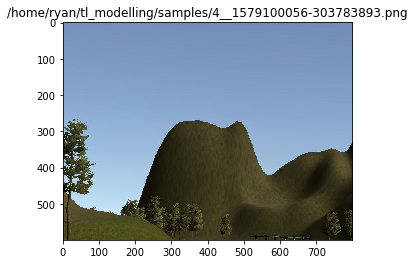

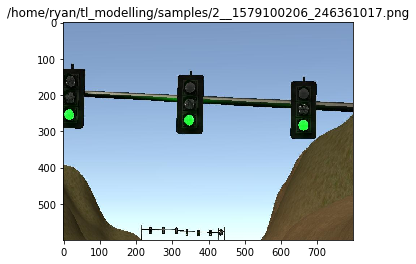

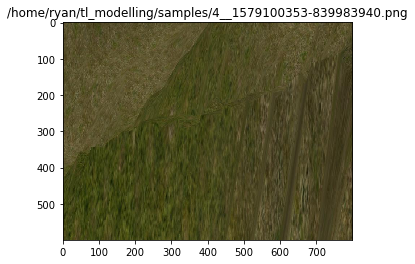

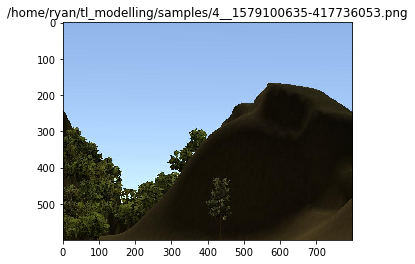

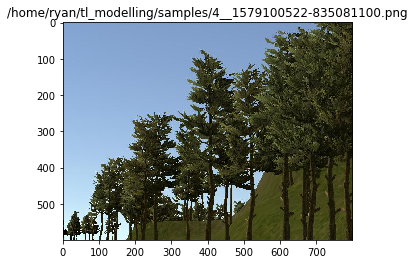

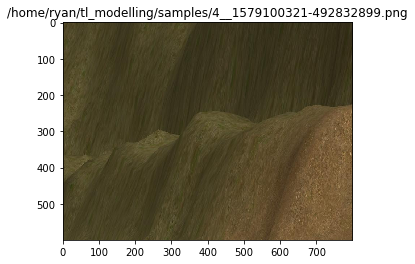

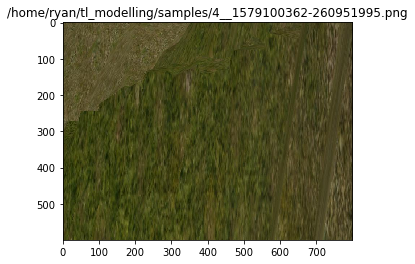

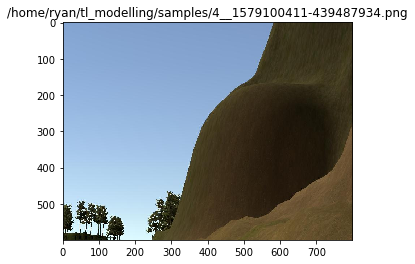

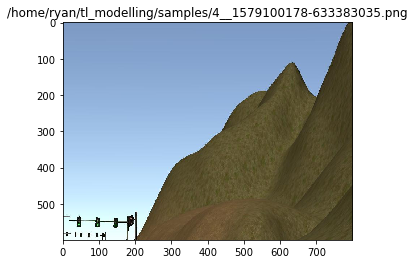

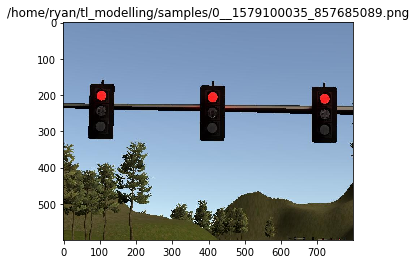

In [16]:
for i in range(10):
    idx = random.randint(0, len(imfiles)-1)
#     im = cv2.imread(imfiles[idx])
    im = mpim.imread(imfiles[idx])
    cv2.imread()
#     if not imfiles[idx][10] == '4':
#         im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(im)
    plt.gca().set_title(imfiles[idx])

In [57]:
def get_samples_list(sampledir):
    samples = [(os.path.join(sampledir, fname), int(fname[0])) \
               for fname in os.listdir(sampledir) \
               if fname[-4:] == '.png']
    
    return samples

def datagen(samples, batch_size=32):
    n_samples = len(samples)
    while True:
        samples = shuffle(samples)
        for offset in range(0, n_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            
            images = []
            labels = []
            for batch_sample in batch_samples:
                im = mpim.imread(batch_sample[0])
                images.append(im)
                labels.append(batch_sample[1])
                
            images = np.array(images)
            labels = keras.utils.to_categorical(np.array(labels), num_classes=5)
            
            yield shuffle(images, labels)

In [58]:
samples = get_samples_list('./samples')

print('red', sum([1 for s in samples if s[1] == 0]))
print('yellow', sum([1 for s in samples if s[1] == 1]))
print('green', sum([1 for s in samples if s[1] == 2]))
print('none', sum([1 for s in samples if s[1] == 4]))

train_samples, valid_samples = train_test_split(samples, test_size=0.25)

train_gen = datagen(train_samples, batch_size=4)
valid_gen = datagen(valid_samples, batch_size=4)

red 142
yellow 8
green 121
none 397


In [59]:
def net_nvidia():
    model = Sequential()
    
    # input processing
    # crop (50 px from top, 20 px from bottom)
#     model.add(Cropping2D(((50, 20), (0, 0)), input_shape=(160, 320, 3)))
    
    # normalise
    model.add(Lambda(lambda x: (x/255)-0.5, input_shape=(600, 800, 3)))
    
    model.add(Conv2D(24, kernel_size=(5, 5), strides=(2, 2)))
    model.add(Activation('relu')) # the paper doesn't mention activation function, but isn't that needed?
    
    model.add(Conv2D(36, kernel_size=(5, 5), strides=(2, 2)))
    model.add(Activation('relu')) 
    
    model.add(Conv2D(48, kernel_size=(5, 5), strides=(2, 2)))
    model.add(Activation('relu')) 
    
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1)))
    model.add(Activation('relu')) 
    
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1)))
    model.add(Dropout(0.30))
    model.add(Activation('relu')) 
    
    model.add(Flatten())
    
    model.add(Dense(100))
    model.add(Activation('relu'))
    
    model.add(Dense(50))
    model.add(Activation('relu'))
    
    model.add(Dense(10))
    model.add(Activation('relu'))
    
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [60]:
def train(model, sample_dir='./samples', batch_size=32, epochs=1):
    samples = get_samples_list(sample_dir)
    train_samples, valid_samples = train_test_split(samples, test_size=0.25)
    train_gen = datagen(train_samples, batch_size=batch_size)
    valid_sen = datagen(valid_samples, batch_size=batch_size)
    
    train_step = math.ceil(len(train_samples)/batch_size)
    valid_step = math.ceil(len(valid_samples)/batch_size)
    
    history = model.fit_generator(train_gen, steps_per_epoch=train_step,
                                  validation_data=valid_gen, validation_steps=valid_step,
                                  epochs=epochs, verbose=1)
    model.save('model.h5')
    return history

In [ ]:
model = net_nvidia()
h = train(model)

Epoch 1/1
13/16 [=======================>......] - ETA: 30s - loss: 1.7754 - acc: 0.4303